In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib import animation
from IPython.display import display, Image
from scipy import signal
import control
%matplotlib inline

Problem - 1 (Stabilizing Inverted Pendulum)

In [13]:
# System parameters
m = 0.1          # mass of bead  
M = 1            # mass of cart 
l = 0.2          # length of rod 
g = 9.8         # gravity

# Initial conditions of generalised coordinates
x0_0 = 0         # cart position
x1_0 = 0.1       # rod angle 
x2_0 = 0         # cart velocity 
x3_0 = 0         # rod angular velocity 
u_0 = 0          # initial cart force 

time = 10          # Duration
dt = 1e-2          # Time step 
n = int(time/dt)   # Number of datapoints

In [14]:
bob_args = ['x' , r'$\theta$', r'$\dot{x}$', r'$\dot{\theta}$']

def Matrix(x, arg): 
        m, M, l, g, u = arg
        x0, x1, x2, x3 = x
        dx0dt = x2
        dx1dt = x3
        lambdat = 1 / (l * (M + m * np.sin(x1)**2))  
        dx2dt = lambdat * (m * l * l * x3**2 * np.sin(x1) - m * g * l * np.sin(x1) * np.cos(x1) + u * l)
        dx3dt = lambdat * ((m + M) * g * np.sin(x1) - m * l * x3 * x3 * np.sin(x1) * np.cos(x1) - u * np.cos(x1))  
        dxdt = np.array([dx0dt, dx1dt, dx2dt, dx3dt])
                               
        return dxdt
                               
def RK_step(x, dt, Matrix, arg):
        k1 = np.array(Matrix(x, arg))
        k2 = np.array(Matrix(x + k1 * dt / 2, arg))
        k3 = np.array(Matrix(x + k2 * dt / 2, arg))
        k4 = np.array(Matrix(x + k3 * dt, arg))
        
        return x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [15]:
def plot(X, labels):
        t = np.arange(0, time, dt)
        plt.figure(figsize=(12, 6))
        plt.title('General variables vs Time')
        for i, x in enumerate(X):
            plt.plot(t, x, label = labels[i])
        plt.xlabel('time')
        plt.legend()
        plt.savefig('1' + labels[0])

        plt.figure(figsize=(12, 6))
        plt.title('Phase-space plot[' + labels[3] + ' vs ' + labels[1] +']')
        plt.plot(X[1], X[3])
        plt.plot(X[1][-1], X[3][-1], 'o', label = "Start")
        plt.plot(X[1][0], X[3][0], '.', label = "Stop")
        plt.xlabel(labels[1])
        plt.ylabel(labels[3])
        plt.legend()
        plt.savefig('2' + labels[0])


        plt.figure(figsize=(12, 6))
        plt.title('Phase-space plot[' + labels[2] + 'vs ' + labels[0] + ']')
        plt.plot(X[0], X[2])
        plt.plot(X[0][-1], X[2][-1], 'o', label = "Start")
        plt.plot(X[0][0], X[2][0], '.', label = "Stop")
        plt.xlabel(labels[0])
        plt.ylabel(labels[2])
        plt.legend()
        plt.savefig('3' + labels[0])
        plt.show()

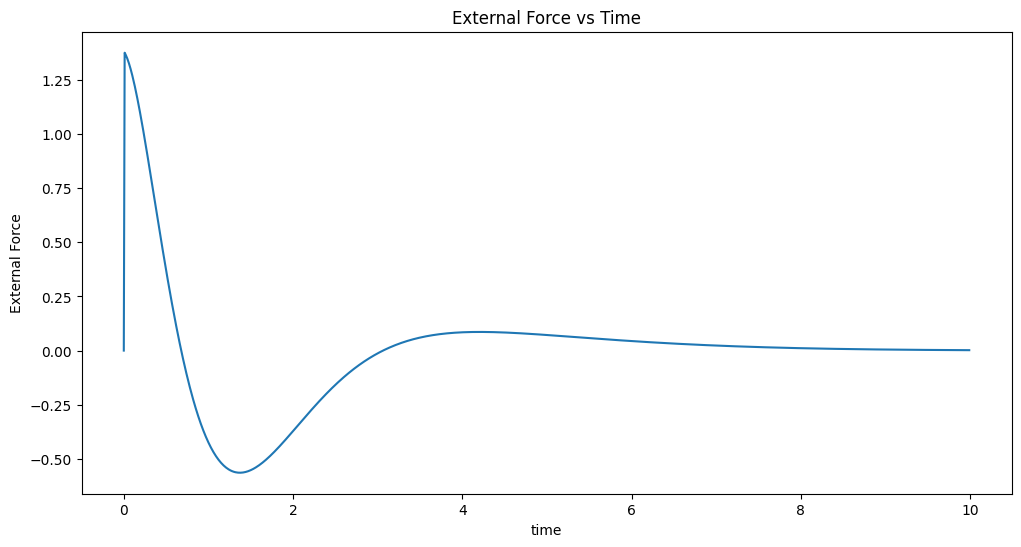

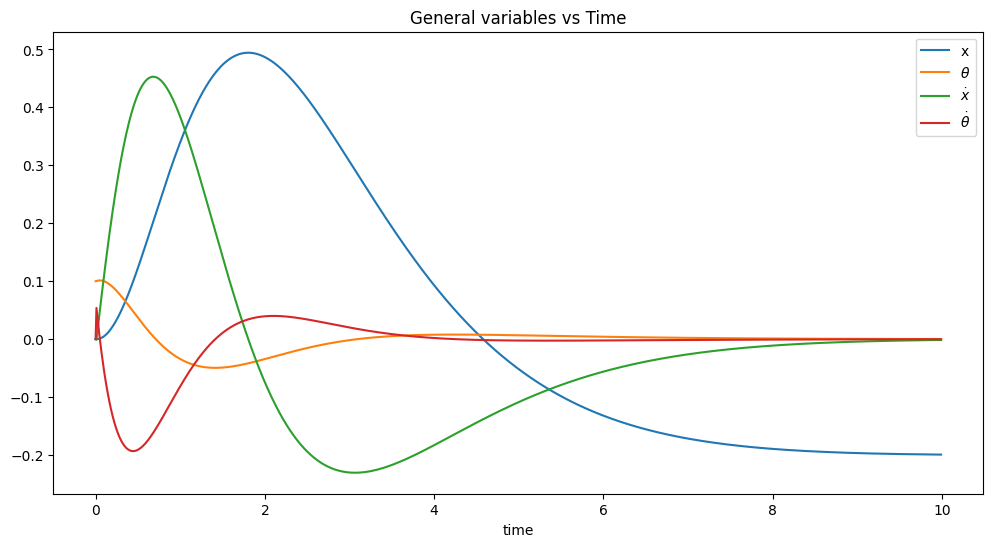

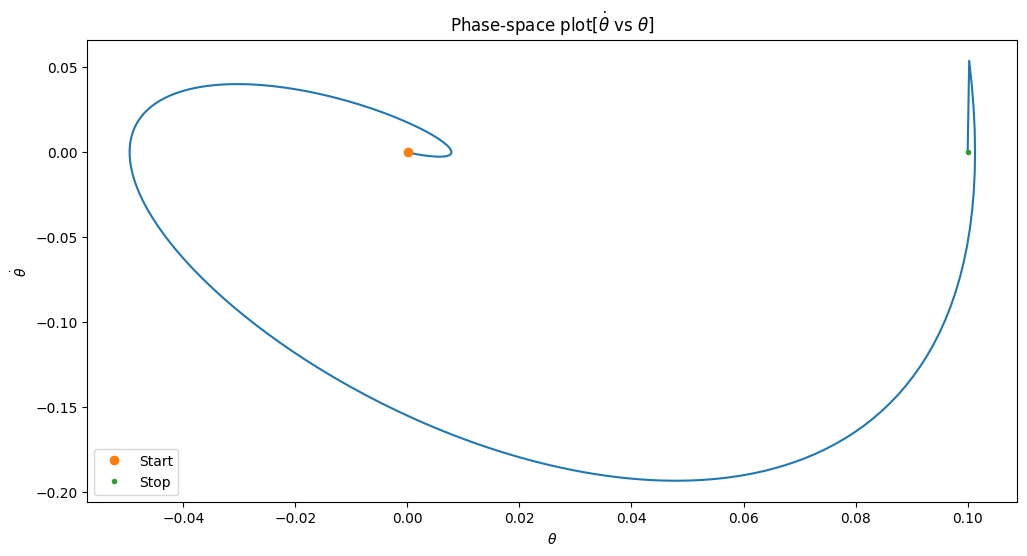

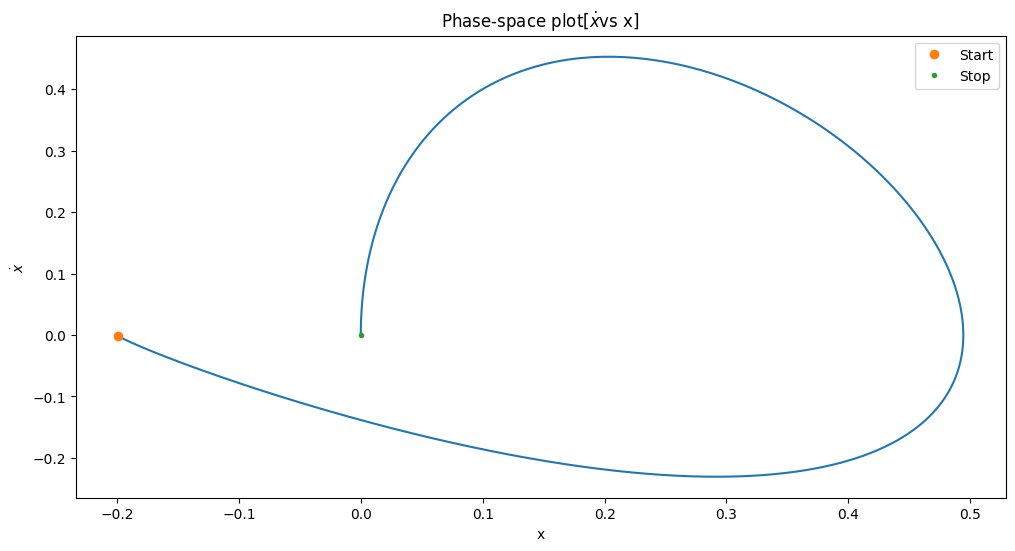

In [16]:
initial = [-0.2, 0, 0, 0]

# Defining the control matrices A and B
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, -m * g / M, 0, 0],
              [0, (m + M) * g / ( M * l), 0, 0]])
                    
B = np.array([[0], 
              [0], 
              [1 / M],
              [-1 / (M * l)]])

# Specifying wanted eigenvalues of the matrix (A - B*K)
poles_PG = [-1.2, -1.3, -1.4, -1.5]
fsf = signal.place_poles(A, B, poles_PG)
K_PG = fsf.gain_matrix

def controller(x, K):
    offset = x - initial
    f = -np.dot(K, offset)
    return f[0]

def integrate(K):

    arg = np.array([m, M, l, g, u_0])
    X = np.zeros((4, n))
    X[:, 0] = np.array([x0_0, x1_0, x2_0, x3_0])
    extF = np.zeros((n))
    extF[0] = u_0

    for i in range(n-1):
        X[:, i + 1] = RK_step(X[:, i], dt, Matrix, arg)
        
        # Calculate the control variable
        f = controller(X[:, i + 1], K)
        extF[i + 1] = f
        arg[4] = f
        
    return X, extF

X_PG, extF_PG = integrate(K_PG)

t = np.arange(0, time, dt)
plt.figure(figsize = (12, 6))
plt.title('External Force vs Time')
plt.plot(t, extF_PG)
plt.xlabel('time')
plt.ylabel('External Force')
plot(X_PG, bob_args)

In [17]:
# For plotting the cart
def cartX(x):
    return np.array([x - l/6, x + l/6, x + l/6, x - l/6, x - l/6])

def Animation(X, file):

    # Defining an array of the time in seconds at each step
    times = np.arange(0, time, dt)
    
    x = X[0] + l * np.sin(X[1])                           # x-co-ord of bob
    y = l * np.cos(X[1])                                  # y-co-ord of bob
    cartY = np.array([l/12, l/12, -l/12, -l/12, l/12])    # y-co-ord of cart
    
    fig = plt.figure(figsize=(12, 6))
    x_min = np.min(X) - l
    x_max = np.max(X) + l
    y_lim = l * 1.5
    plt.xlim(x_min, x_max)
    plt.ylim(-y_lim, y_lim)

    # Defining the different elements in the animation
    floor, = plt.plot([x_min, x_max], [-l/12, -l/12], color = 'black', linewidth = 1)  #Floor
    tail, = plt.plot(x[0], y[0], '--', color = "blue")                                 # Previous position of the pendulum bead
    cart, = plt.plot(cartX(X[0, 0]), cartY, color = "red")                             # The cart 
    rod, = plt.plot([X[0, 0], x[0]], [0, y[0]], color = "black")                       # The pendulum rod of length l
    bob, = plt.plot(x[0], y[0], 'o', color = "red", ms = 6)                            # The pendulum bob
    text = plt.text(0, -0.1, r'$t = %.2f$s'%(times[0]))                                # Text box with elapsed time

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Stabilizing Inverted Pendulum")
    
    # Calculate the number of frames
    FPS = 30
    totalframes = int(FPS * time)
    PPS = int(n / totalframes)

    # Animation function. This is called sequentially
    def animate(j):
        t = j * PPS
        tail.set_xdata(x[:t])
        tail.set_ydata(y[:t])
        cart.set_xdata(cartX(X[0, t])) 
        cart.set_ydata(cartY)
        rod.set_xdata([X[0, t], x[t]])
        rod.set_ydata([0, y[t]])
        bob.set_xdata(x[t])
        bob.set_ydata(y[t])        
        text.set_text(r'$t =  %.2f$s'%(times[t]))

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=totalframes)
    anim.save(file, writer='pillow', fps = FPS)

    plt.close(anim._fig)

    # Display the animation
    gif = open(file, 'rb')
    display(Image(gif.read()))

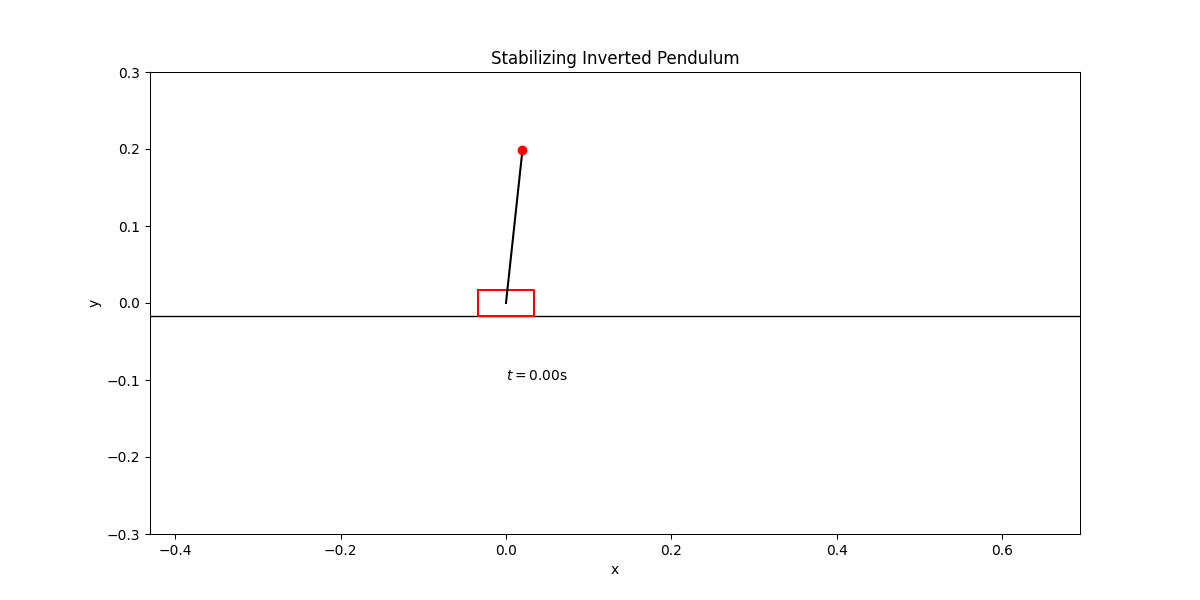

In [18]:
Animation(X_PG, "inverted_stabilize.gif")

Problem 2 - 2 Body Spring Dynamics

In [19]:
# Particle parameters
m = 0.2          # mass of particle 1  
M = 0.3          # mass of particle 2 
l = 1            # rest length 
k = 0.8          # spring constant

x0 = 0         # Posistion of mass m
x1 = 1.3       # Posistion of mass M 
x2 = 0         # Velocity of mass m
x3 = 0         # Velocity of mass M

time = 10          # Duration
dt = 1e-2          # Time step 
n = int(time / dt) # Number of datapoints

spring_args = ['x1', 'x2', 'v1', 'v2']

In [20]:
def Matrix(x, args):
    m, M, l, k = args
    x0, x1, x2, x3 = x
    dx0dt = x2
    dx1dt = x3
    dx2dt = k * (x1 - x0 - l) / m
    dx3dt = k * (x0 + l - x1) / M
    dxdt = np.array([dx0dt, dx1dt, dx2dt, dx3dt])

    return dxdt

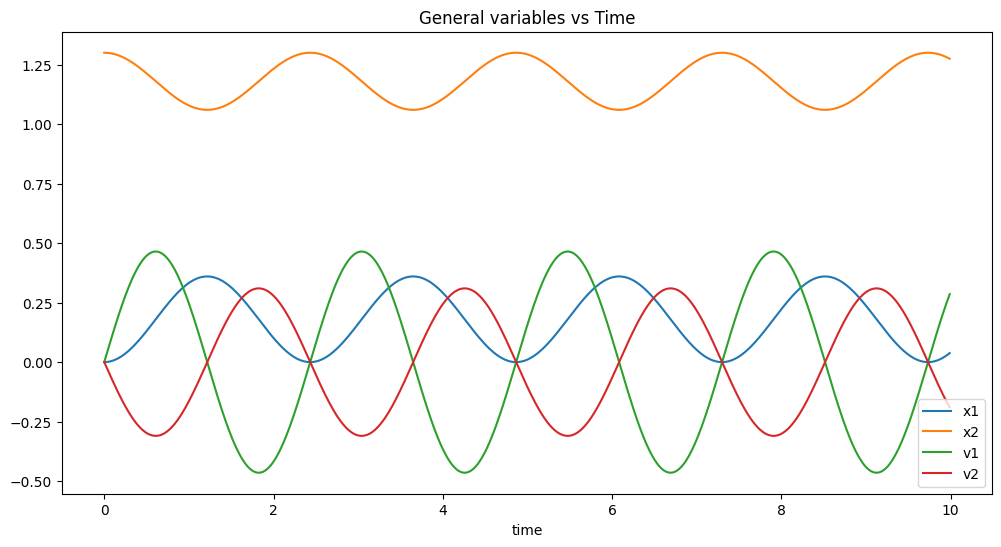

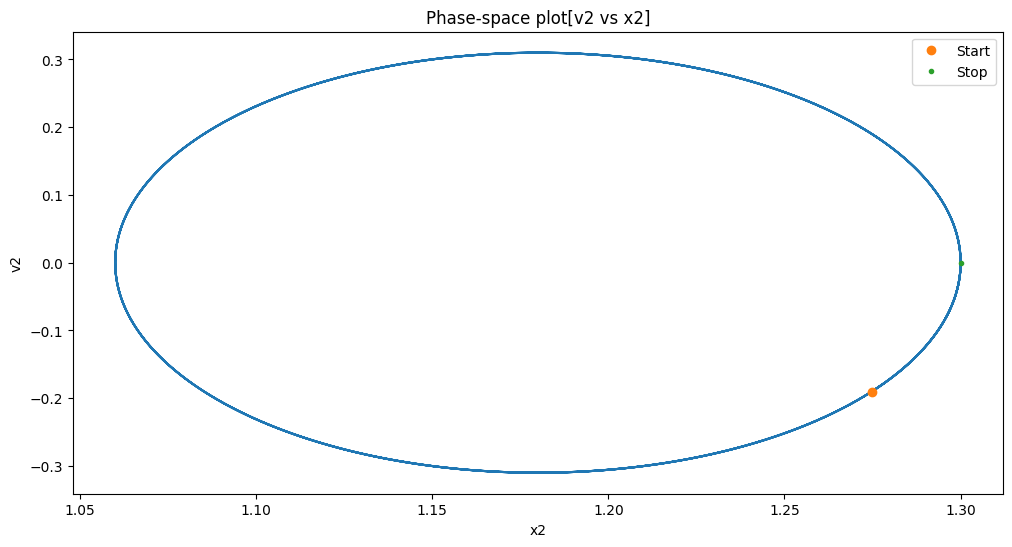

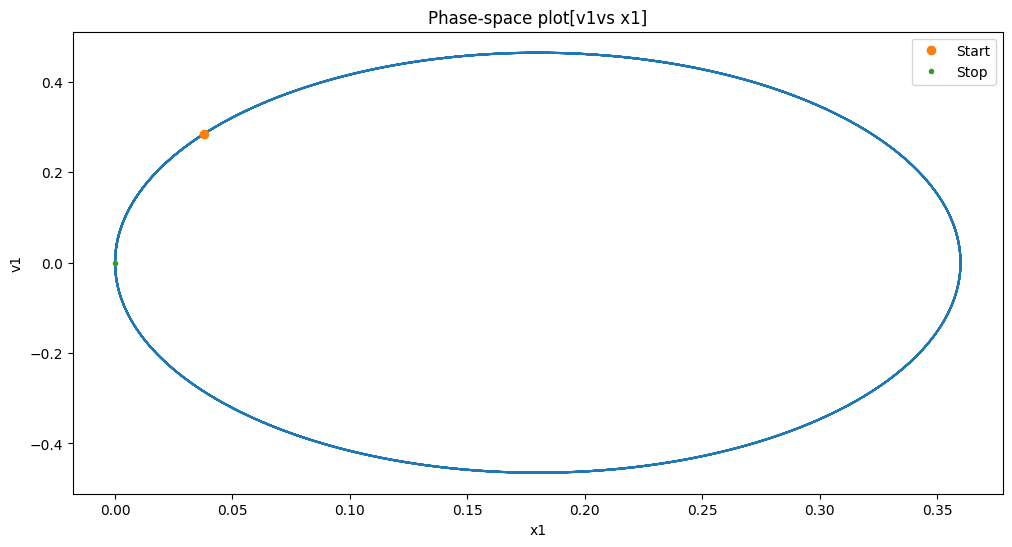

In [21]:
args = np.array([m, M, l, k])
X = np.zeros((4, n))
X[:, 0] = np.array([x0, x1, x2, x3])
for i in range(n - 1):
    X[:, i + 1] = RK_step(X[:, i], dt, Matrix, args)
        
plot(X, spring_args)